In [1]:
# -*- coding: utf-8 -*-

class Environment(object):

    def __init__(self, agents, initial_state):
        self.agents = agents
        self.initial_state = initial_state
        self.state = initial_state

    def run(self, steps=10000, viewer=None):
        self.state = self.initial_state
        for step in range(steps):
            if self.is_completed(self.state):
                return
            self.step(viewer=viewer)

    def step(self, viewer=None):
        "This method evolves one step in time"
        if not self.is_completed(self.state):
            for agent in self.agents:
                action = agent.program(self.percept(agent, self.state))
                next_state = self.do_action(self.state, action, agent)
                if viewer:
                    viewer.event(self.state, action, next_state, agent)
                self.state = next_state
                if self.is_completed(self.state):
                    return

    def do_action(self, state, action, agent):
        "Override this method to apply an action performed by an agent to a state and return a new state"
        raise NotImplementedError()

    def is_completed(self, state):
        "Override this method when the environment have terminal states"
        return False

    def percept(self, agent, state):
        "This method make agent's perception"
        return self.state


class RLEnvironment(Environment):

    def __init__(self, agents, initial_state):
        super(RLEnvironment, self).__init__(agents, initial_state)

    def step(self, viewer=None):
        super(RLEnvironment, self).step(viewer)
        for agent in self.agents:
            agent.set_reward(self.reward(self.state, agent), self.is_completed(self.state))

    def reward(self, state, agent):
        raise NotImplementedError()

In [2]:
# -*- coding: utf-8 -*-
from collections import defaultdict, Counter
import math
import random
from simpleai.search.utils import argmax
import pickle
try:
    import matplotlib.pyplot as plt
    import numpy
except:
    plt = None  # lint:ok
    numpy = None  # lint:ok


def make_at_least_n_times(optimistic_reward, min_n):
    def at_least_n_times_exploration(actions, utilities, temperature, action_counter):
        utilities = [utilities[x] for x in actions]
        for i, utility in enumerate(utilities):
            if action_counter[actions[i]] < min_n:
                utilities[i] = optimistic_reward
        d = dict(zip(actions, utilities))
        uf = lambda action: d[action]
        return argmax(actions, uf)

    return at_least_n_times_exploration


def boltzmann_exploration(actions, utilities, temperature, action_counter):
    '''returns an action with a probability depending on utilities and temperature'''
    utilities = [utilities[x] for x in actions]
    temperature = max(temperature, 0.01)
    _max = max(utilities)
    _min = min(utilities)
    if _max == _min:
        return random.choice(actions)

    utilities = [math.exp(((u - _min) / (_max - _min)) / temperature) for u in utilities]
    probs = [u / sum(utilities) for u in utilities]
    i = 0
    tot = probs[i]
    r = random.random()
    while i < len(actions) and r >= tot:
        i += 1
        tot += probs[i]
    return actions[i]


def make_exponential_temperature(initial_temperature, alpha):
    '''returns a function like initial / exp(n * alpha)'''
    def _function(n):
        try:
            return initial_temperature / math.exp(n * alpha)
        except OverflowError:
            return 0.01
    return _function


class PerformanceCounter(object):

    def __init__(self, learners, names=None):
        self.learners = learners
        for i, learner in enumerate(learners):
            self.update_set_reward(learner)
            learner.accumulated_rewards = []
            learner.known_states = []
            learner.temperatures = []
            if names is None:
                learner.name = 'Learner %d' % i
            else:
                learner.name = names[i]

    def update_set_reward(self, learner):
        def set_reward(reward, terminal=False):
            if terminal:
                if len(learner.accumulated_rewards) > 0:
                    learner.accumulated_rewards.append(learner.accumulated_rewards[-1] + reward)
                else:
                    learner.accumulated_rewards.append(reward)
                learner.known_states.append(len(learner.Q))
                learner.temperatures.append(learner.temperature_function(learner.trials))
            learner.old_set_reward(reward, terminal)
        learner.old_set_reward = learner.set_reward
        learner.set_reward = set_reward

    def _make_plot(self, ax, data_name):
        for learner in self.learners:
            data = numpy.array(getattr(learner, data_name))
            ax.plot(numpy.arange(len(data)), data, label=learner.name)
        nice_name = data_name.replace('_', ' ').capitalize()
        ax.set_title(nice_name)
        ax.legend()

    def show_statistics(self):
        f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
        self._make_plot(ax1, 'accumulated_rewards')
        self._make_plot(ax2, 'known_states')
        self._make_plot(ax3, 'temperatures')
        plt.show()


class RLProblem(object):

    def actions(self, state):
        '''Returns the actions available to perform from `state`.
           The returned value is an iterable over actions.
        '''
        raise NotImplementedError()

    def update_state(self, percept, agent):
        'Override this method if you need to clean perception to a given agent'
        return percept


def inverse(n):
    if n == 0:
        return 1
    return 1.0 / n


def state_default():
    return defaultdict(int)


class QLearner(object):

    def __init__(self, problem, temperature_function=inverse,
                 discount_factor=1,
                 exploration_function=boltzmann_exploration,
                 learning_rate=inverse):

        self.Q = defaultdict(state_default)
        self.problem = problem
        self.discount_factor = discount_factor
        self.temperature_function = temperature_function
        self.exploration_function = exploration_function
        self.learning_rate = learning_rate

        self.last_state = None
        self.last_action = None
        self.last_reward = None
        self.counter = defaultdict(Counter)
        self.trials = 0

    def set_reward(self, reward, terminal=False):
        self.last_reward = reward
        if terminal:
            self.trials += 1
            self.Q[self.last_state][self.last_action] = reward

    def program(self, percept):
        s = self.last_state
        a = self.last_action

        state = self.problem.update_state(percept, self)
        actions = self.problem.actions(state)

        if len(actions) > 0:
            current_action = self.exploration_function(actions, self.Q[state],
                                                       self.temperature_function(self.trials),
                                                       self.counter[state])
        else:
            current_action = None

        if s is not None and current_action:
            self.counter[s][a] += 1
            self.update_rule(s, a, self.last_reward, state, current_action)

        self.last_state = state
        self.last_action = current_action
        return current_action

    def update_rule(self, s, a, r, cs, ca):
        raise NotImplementedError

    def dump(self, path):
        self.temperature_function = inverse
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    @classmethod
    def load(self, path):
        with open(path, 'rb') as f:
            return pickle.load(f)


class TDQLearner(QLearner):

    def update_rule(self, s, a, r, cs, ca):
        lr = self.learning_rate(self.counter[s][a])
        self.Q[s][a] += lr * (r + self.discount_factor * max(self.Q[cs].values()) - self.Q[s][a])


class SARSALearner(QLearner):

    def update_rule(self, s, a, r, cs, ca):
        lr = self.learning_rate(self.counter[s][a])
        self.Q[s][a] += lr * (r + self.discount_factor * self.Q[cs][ca] - self.Q[s][a])

In [ ]:
# I have made some changes to the RLenvironment.py in simpleai library to make it interactive.

In [3]:
from simpleai.machine_learning.reinforcement_learning import TDQLearner, SARSALearner, RLProblem, \
                                                             make_exponential_temperature, \
                                                             PerformanceCounter
import random
from simpleai.environments import RLEnvironment

class TicTacToeGame(RLEnvironment):
    def __init__(self, agents):
        initial_state = tuple(tuple(' ' for _ in range(3)) for _ in range(3))  # Empty 3x3 board as tuple of tuples
        super(TicTacToeGame, self).__init__(agents, initial_state)

    def do_action(self, state, action, agent):
        """Apply the agent's action to the state and return the new state."""
        if not isinstance(action, tuple) or len(action) != 2:
            raise ValueError("Action should be a tuple of (row, col)")

        new_state = [list(row) for row in state]  # Convert tuples to lists for modification
        row, col = action
        new_state[row][col] = agent.play_with
        return tuple(tuple(row) for row in new_state)  # Convert back to tuple of tuples

    def is_completed(self, state):
        """Check if the game is completed with a win or a draw."""
        for row in state:
            if row[0] == row[1] == row[2] != ' ':
                return True
        for col in range(3):
            if state[0][col] == state[1][col] == state[2][col] != ' ':
                return True
        if state[0][0] == state[1][1] == state[2][2] != ' ' or \
           state[0][2] == state[1][1] == state[2][0] != ' ':
            return True
        if all(cell != ' ' for row in state for cell in row):
            return True  # Draw
        return False

    def reward(self, state, agent):
        """Reward the agent for winning, losing, or drawing the game."""
        if self.is_completed(state):
            for row in state:
                if row[0] == row[1] == row[2] == agent.play_with:
                    return 1
            return -1
        return 0  # No reward for non-terminal states

    def percept(self, agent, state):
        """Give the agent the current state of the game."""
        return state

    def print_state(self):
        """Print the board in a grid format."""
        print("  0 1 2")
        for i, row in enumerate(self.state):
            print(f"{i} {' '.join(row)}")
    
    def print_result(self):
        """Print the result of the game."""
        if self.is_completed(self.state):
            # Determine if the game was a win or a draw
            for row in self.state:
                if row[0] == row[1] == row[2] != ' ':
                    winner = row[0]
                    if winner == 'X':
                        print("Agent wins!")
                    elif winner == 'O':
                        print("Human wins!")
                    return
            for col in range(3):
                if self.state[0][col] == self.state[1][col] == self.state[2][col] != ' ':
                    winner = self.state[0][col]
                    if winner == 'X':
                        print("Agent wins!")
                    elif winner == 'O':
                        print("Human wins!")
                    return
            if self.state[0][0] == self.state[1][1] == self.state[2][2] != ' ' or \
               self.state[0][2] == self.state[1][1] == self.state[2][0] != ' ':
                winner = self.state[1][1]
                if winner == 'X':
                    print("Agent wins!")
                elif winner == 'O':
                    print("Human wins!")
            else:
                print("It's a draw!")
        else:
            print("Game is not yet completed.")

class TicTacToeProblem(RLProblem):
    def __init__(self):
        self.possible_actions = [(row, col) for row in range(3) for col in range(3)]

    def actions(self, state):
        """Return available actions for a given state (empty spots on the board)."""
        return [(row, col) for row, col in self.possible_actions if state[row][col] == ' ']
    
    def update_state(self, percept, agent):
        """Simply return the current percept (game state) as the new state."""
        return percept


In [ ]:
# The main code starts here 
# Above code is added to avoide any importing error
# Only class names used, are from simpleai document to avoide any error 

Training TQD Learner with a random player, please wait...


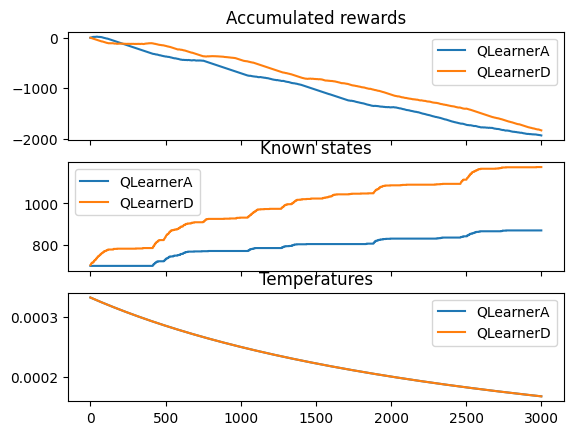

Do you like to play with TDQ Agent?
Current state:
   0   1   2
 +---+---+---+
0|   | X |   |
 +---+---+---+
1|   |   |   |
 +---+---+---+
2|   |   |   |
 +---+---+---+


Enter row (0-2):  0
Enter column (0-2):  0


('reward:', 0)
Current state:
   0   1   2
 +---+---+---+
0| O | X |   |
 +---+---+---+
1|   |   |   |
 +---+---+---+
2| X |   |   |
 +---+---+---+


Enter row (0-2):  1
Enter column (0-2):  1


('reward:', 0)
Current state:
   0   1   2
 +---+---+---+
0| O | X |   |
 +---+---+---+
1|   | O |   |
 +---+---+---+
2| X |   | X |
 +---+---+---+


Enter row (0-2):  2
Enter column (0-2):  1


('reward:', 0)
Current state:
   0   1   2
 +---+---+---+
0| O | X |   |
 +---+---+---+
1| X | O |   |
 +---+---+---+
2| X | O | X |
 +---+---+---+


Enter row (0-2):  0
Enter column (0-2):  2


('reward:', 0)
('reward:', -1)
Final state:
  0 1 2
0 O X O
1 X O X
2 X O X
It's a draw!


In [4]:
class TicTacToePlayer(TDQLearner):
    def __init__(self, play_with, *args, **kwargs):
        problem = TicTacToeProblem()
        super(TicTacToePlayer, self).__init__(problem, *args, **kwargs)
        self.play_with = play_with

class RandomPlayer:
    def __init__(self, play_with):
        self.play_with = play_with

    def program(self, state):
        """Randomly chooses an available position."""
        available_actions = [(row, col) for row in range(3) for col in range(3) if state[row][col] == ' ']
        return random.choice(available_actions) if available_actions else None

    def set_reward(self, reward, completed):
        pass

class HumanPlayer:
    def __init__(self, play_with):
        self.play_with = play_with

    def set_reward(self, reward, completed):
        print(('reward:', reward))

    def program(self, state):
        print("Current state:")
        print_grid(state)
        while True:
            try:
                row = int(input("Enter row (0-2): "))
                col = int(input("Enter column (0-2): "))
                if state[row][col] == ' ':
                    return (row, col)
                else:
                    print("Cell is already taken. Try again.")
            except (ValueError, IndexError):
                print("Invalid input. Try again.")

def print_grid(state):
    """Print the board in a grid format."""
    print("   0   1   2")
    print(" +---+---+---+")
    for i, row in enumerate(state):
        row_display = f"{i}| {' | '.join(row)} |"
        print(row_display)
        print(" +---+---+---+")

if __name__ == '__main__':
    # Initialize players
    a = TicTacToePlayer('X', temperature_function=make_exponential_temperature(1, 0.01))
    b = RandomPlayer('O')
    c = HumanPlayer('O')
    
    # Initialize the Tic-Tac-Toe game environment
    game = TicTacToeGame([a, b])
    
    # Training phase (Q-learning agent vs Random player)
    print('Training TQD Learner with a random player, please wait...')
    game.agents = [a, b]
    for i in range(3000):
        game.run()
    
    # Save the trained Q-learning agent
    a.dump('qlearner_agent')
    
    # Load the trained Q-learning agent
    d = TicTacToePlayer.load('qlearner_agent')
    d.play_with = 'O'
    
    # Evaluation phase (Q-learning agent vs Random player)
    game.agents = [a, d]
    per = PerformanceCounter(game.agents, ['QLearnerA', 'QLearnerD'])
    for i in range(3000):
        game.run()
    per.show_statistics()
    
    # Evaluation phase (Q-learning agent vs Human player)
    game.agents = [a, c]
    print('Do you like to play with TDQ Agent?')
    game.run()
    print("Final state:")
    game.print_state()
    game.print_result()

Training SARSA Learner with a random player, please wait...


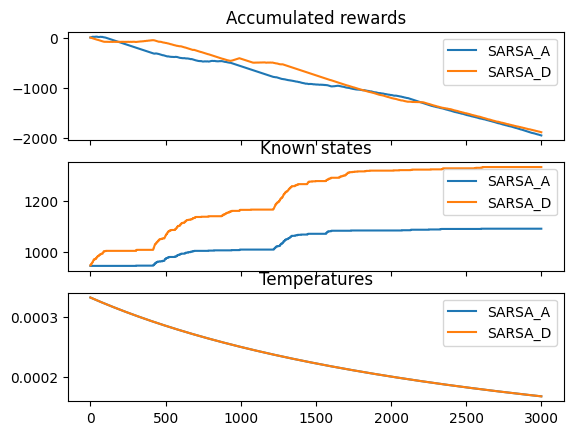

Do you like to play with SARSA Agent?
Current state:
   0   1   2
 +---+---+---+
0|   | X |   |
 +---+---+---+
1|   |   |   |
 +---+---+---+
2|   |   |   |
 +---+---+---+


Enter row (0-2):  0
Enter column (0-2):  0


('reward:', 0)
Current state:
   0   1   2
 +---+---+---+
0| O | X |   |
 +---+---+---+
1|   |   | X |
 +---+---+---+
2|   |   |   |
 +---+---+---+


Enter row (0-2):  1
Enter column (0-2):  1


('reward:', 0)
Current state:
   0   1   2
 +---+---+---+
0| O | X |   |
 +---+---+---+
1|   | O | X |
 +---+---+---+
2|   |   | X |
 +---+---+---+


Enter row (0-2):  0
Enter column (0-2):  2


('reward:', 0)
Current state:
   0   1   2
 +---+---+---+
0| O | X | O |
 +---+---+---+
1|   | O | X |
 +---+---+---+
2| X |   | X |
 +---+---+---+


Enter row (0-2):  2
Enter column (0-2):  1


('reward:', 0)
('reward:', -1)
Final state:
  0 1 2
0 O X O
1 X O X
2 X O X
It's a draw!


In [12]:
class TicTacToePlayer(SARSALearner):
    def __init__(self, play_with, *args, **kwargs):
        problem = TicTacToeProblem()
        super(TicTacToePlayer, self).__init__(problem, *args, **kwargs)
        self.play_with = play_with

class RandomPlayer:
    def __init__(self, play_with):
        self.play_with = play_with

    def program(self, state):
        """Randomly chooses an available position."""
        available_actions = [(row, col) for row in range(3) for col in range(3) if state[row][col] == ' ']
        return random.choice(available_actions) if available_actions else None

    def set_reward(self, reward, completed):
        pass

class HumanPlayer:
    def __init__(self, play_with):
        self.play_with = play_with

    def program(self, state):
        """human will input the move."""
        print("Current state:")
        print_grid(state)
        while True:
            try:
                row = int(input("Enter row (0-2): "))
                col = int(input("Enter column (0-2): "))
                if state[row][col] == ' ':
                    return (row, col)
                else:
                    print("Cell is already taken. Try again.")
            except (ValueError, IndexError):
                print("Invalid input. Try again.")

    def set_reward(self, reward, completed):
        print(('reward:', reward))

def print_grid(state):
    """Print the board in a grid format."""
    print("   0   1   2")
    print(" +---+---+---+")
    for i, row in enumerate(state):
        row_display = f"{i}| {' | '.join(row)} |"
        print(row_display)
        print(" +---+---+---+")

if __name__ == '__main__':
    # Initialize players
    a = TicTacToePlayer('X', temperature_function=make_exponential_temperature(1, 0.01))
    b = RandomPlayer('O')
    c = HumanPlayer('O')
    
    # Initialize the Tic-Tac-Toe game environment
    game = TicTacToeGame([a, b])
    
    # Training phase (SARSA agent vs Random player)
    print('Training SARSA Learner with a random player, please wait...')
    game.agents = [a, b]
    for i in range(3000):
        game.run()
    
    # Save the trained SARSA agent
    a.dump('sarsa_agent')
    
    # Load the trained SARSA agent
    d = TicTacToePlayer.load('sarsa_agent')
    d.play_with = 'O'
    
    # Evaluation phase (SARSA agent vs Random player)
    game.agents = [a, d]
    per = PerformanceCounter(game.agents, ['SARSA_A', 'SARSA_D'])
    for i in range(3000):
        game.run()
    per.show_statistics()
    
    # Evaluation phase (SARSA agent vs Human player)
    game.agents = [a, c]
    print('Do you like to play with SARSA Agent?')
    game.run()
    print("Final state:")
    game.print_state()
    game.print_result()  

In [ ]:
# The model may not perform well in the very first game but in 2-3 games it can perform outstanding and camparision can be done between two models.